In [61]:
import gym
import time
import numpy as np

import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Sarsa
Having seen Q-learning, we can apply another _tabular_, _one-step_ TD method, Sarsa. Again we learn the $Q$ function by bootstrapping, the update rule of the Sarsa algorithm is defined by,
$$
Q\left(S_{t}, A_{t}\right) \leftarrow Q\left(S_{t}, A_{t}\right)+\alpha\left[R_{t+1}+\gamma Q\left(S_{t+1}, A_{t+1}\right)-Q\left(S_{t}, A_{t}\right)\right]
$$

# <img src="../img/sarsa_CH6.4.png">

This algorithm as just defined, is found in chapter 6.4 by Barto & Sutton. The big difference with Q-learning is that we don't take the max value over the $Q$ function but instead let the policy pick an action.  

Similar to Q-learning we will directly apply $\epsilon$ decay and evaluate the algorithm on the frozenlake environment.

In [62]:
def print_statistics(Q, num_episodes, rewards_total, steps_total, eps_decay=None, Q_2=None):
    """Used to display the results of the implemented algorithms"""
    if Q_2 is not None:
        print("Q_1-function:", Q)
        print("Q_2-function:", Q_2)
    else:
        print("Q-function:", Q)
    
    print("Percentage of episodes finished succesfully: {0}".format(
        sum(rewards_total)/num_episodes))
    print("Percentage of episodes finished succesfully (last 100 episodes): {0}".format(
        sum(rewards_total[-100:])/100))

    print("Average number of steps: %.2f" % (sum(steps_total)/num_episodes))
    print("Average number of steps (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))

    plt.figure(figsize=(12, 5))
    plt.title("Rewards")
    plt.ylabel("Episode length")
    plt.xlabel("Episode")
    plt.bar(np.arange(len(rewards_total)), rewards_total, alpha=0.6, color='green')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.title("Steps")
    plt.ylabel("Episode length")
    plt.xlabel("Episode")
    plt.bar(np.arange(len(steps_total)), steps_total, alpha=0.6, color='red')
    plt.show()
    
    if eps_decay is not None:
        plt.figure(figsize=(12, 5))
        plt.title("$\epsilon$-greedy values")
        plt.ylabel("$\epsilon$ values")
        plt.xlabel("Episode")
        plt.bar(np.arange(len(eps_decay)), eps_decay, alpha=0.6, color='blue')
        plt.show()

### Sarsa comparison on both stochastic and deterministic environment
It is assumed that in the stochastic environment the Q-function is harder to estimate, due to the action not being deterministic. This will be observed more clearly in the empirical results.

Episode finished after 8 steps, with reward 0
Episode finished after 6 steps, with reward 1
Episode finished after 6 steps, with reward 1
Episode finished after 6 steps, with reward 1
Episode finished after 6 steps, with reward 1
Q-function: [[0.21277254 0.44221349 0.21851251 0.21802114]
 [0.21743774 0.15       0.22206408 0.2156747 ]
 [0.22584009 0.24363656 0.2266259  0.22618586]
 [0.2257834  0.15       0.22321518 0.22791894]
 [0.21882463 0.81450625 0.15       0.22107489]
 [0.25       0.25       0.25       0.25      ]
 [0.15       0.3995008  0.15       0.23515453]
 [0.25       0.25       0.25       0.25      ]
 [0.23201962 0.15       0.857375   0.22683499]
 [0.24196    0.2402     0.9025     0.15      ]
 [0.24196    0.95       0.15       0.23868488]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.15       0.245      0.242      0.2431    ]
 [0.2431     0.25       1.         0.245     ]
 [0.25       0.25       0.25       0.25      ]]
Perce

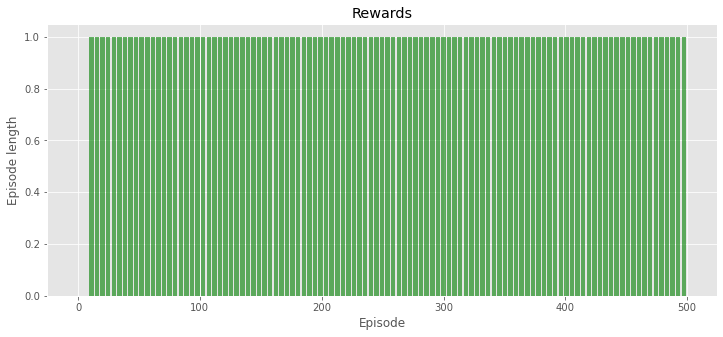

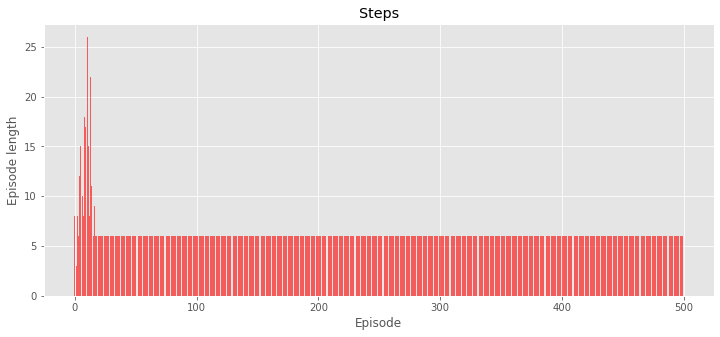

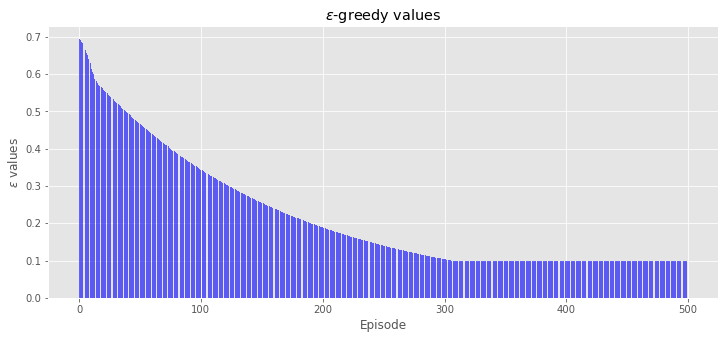

In [63]:
env = gym.make('FrozenLake-v0', is_slippery=False)

def Sarsa(env, num_episodes=500, gamma=0.95, alpha=0.4, epsilon=0.7, print_i=50):

    def choose_action(Q, obs, epsilon=0.01):
        """Helper function to choose actions from Q"""
        if np.random.normal() < epsilon:
            random_values = Q[obs] + np.random.randn(nA)/1000
            return np.argmax(random_values)
        else:
            return np.argmax(Q[obs])
    
    nS = env.observation_space.n
    nA = env.action_space.n
    
    # Track statistics
    rewards_total = []
    steps_total = []
    egreedy_total = []
    
    # Decaying epsilon greedy
    epsilon_final = 0.1
    epsilon_decay = 0.999
    
    # Initialize Q
    Q = np.ones([nS, nA]) * 1/nA

    # Loop for each episode
    for i in range(num_episodes):
        # Initiatize S
        obs = env.reset()
        
        # Choose A from S using policy derived from Q,
        # using epsilon-greedy exploration
        action = choose_action(Q, obs, epsilon)

        # These will be the S and A variables in the while
        # loop.
        prev_obs = None
        prev_action = None

        steps = 0

        # Loop for each step of the episode
        while True:
            steps += 1
            
            # Take action A, observe R, S'
            obs, reward, done, info = env.step(action)
            # Choose A' from S' using policy derived from Q,
            # using epsilon-greedy exploration
            action = choose_action(Q, obs, epsilon)

            # Update the epsilon greedy decay
            if epsilon > epsilon_final:
                epsilon *= epsilon_decay

            # Skip the update for the first step
            if prev_obs is not None:
                # There will be no next A' and S' so,
                if done:
                    Q[prev_obs][prev_action] += alpha * (
                        reward - Q[prev_obs][prev_action])
                else:
                    # The full update rule,
                    # Q(S, A) <- Q(S, A) + alpha [R + gamma Q(S', A') - Q(S, A)]
                    # The TD target, R + gamma Q(S', A')
                    td_target = reward + gamma * Q[obs][action]
                    # The TD error, R + gamma Q(S', A') - Q(S, A)
                    td_error = td_target - Q[prev_obs][prev_action]
                    # Finally, the update,
                    Q[prev_obs][prev_action] += alpha * td_error


            # S <- S', A <- A'
            prev_obs = obs
            prev_action = action 

            # until S is terminal
            if done:
                steps_total.append(steps)
                rewards_total.append(reward)
                egreedy_total.append(epsilon)
                if i % print_i == 0:
                    print("Episode finished after %i steps, with reward %i" % (steps, reward))
                break
                
    print_statistics(Q, num_episodes, rewards_total, steps_total, egreedy_total)
    
Sarsa(env, num_episodes=500, print_i=100)

It should be noted the $Q$-function is optimistically initialized as all having a value of 0.25, while having 4 actions. This is observed to converge slightly faster, compared to initializing the $Q$-function as zero vectors. Additionally, the $Q$-function converges extremely fast compared to Q-learning.

Episode finished after 3 steps, with reward 0
Episode finished after 67 steps, with reward 1
Episode finished after 50 steps, with reward 0
Episode finished after 42 steps, with reward 1
Q-function: [[0.21724226 0.04290571 0.03331092 0.0412221 ]
 [0.0220935  0.02268882 0.02940867 0.17049938]
 [0.02524487 0.02702503 0.0194197  0.10138086]
 [0.01841775 0.01822798 0.02591302 0.0637247 ]
 [0.27984469 0.03186381 0.04062891 0.04990805]
 [0.25       0.25       0.25       0.25      ]
 [0.00336332 0.00336219 0.06712142 0.00351778]
 [0.25       0.25       0.25       0.25      ]
 [0.08073371 0.0841952  0.07552663 0.37861508]
 [0.08511768 0.47247361 0.09538812 0.08103169]
 [0.38599268 0.02798046 0.03179204 0.03437372]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.13753699 0.13945008 0.71007141 0.15      ]
 [0.2252511  0.94811111 0.2401     0.2431    ]
 [0.25       0.25       0.25       0.25      ]]
Percentage of episodes finished succesfully: 0.5

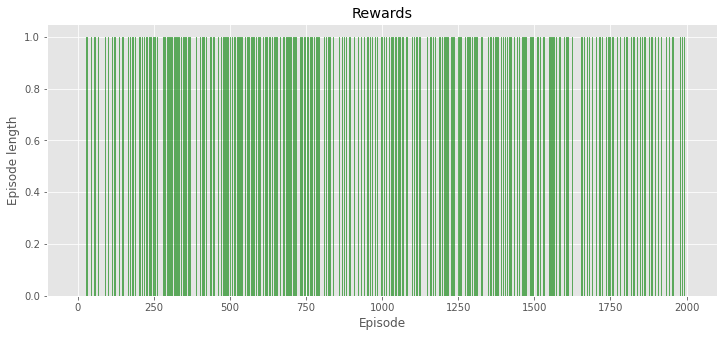

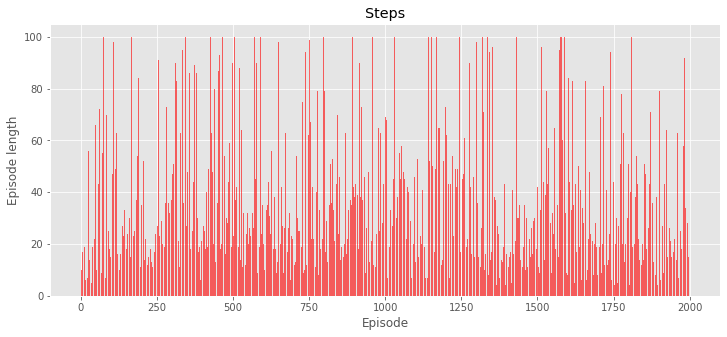

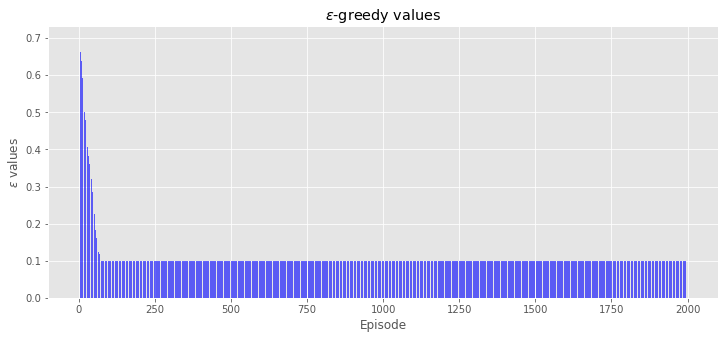

In [64]:
env = gym.make('FrozenLake-v0', is_slippery=True)

Sarsa(env, num_episodes=2000, print_i=500)

Finally, we observe the expected behavior of the steps behaving unstable due to the stochastic behavior of the environment.

### Expected Sarsa
Consider the learning algorithm that is just like Q-learning except that instead of the
maximum over next state–action pairs it uses the expected value, taking into account
how likely each action is under the current policy. In which we define the update function as follows,

\begin{aligned}
Q\left(S_{t}, A_{t}\right) & \leftarrow Q\left(S_{t}, A_{t}\right)+\alpha\left[R_{t+1}+\gamma \mathbb{E}_{\pi}\left[Q\left(S_{t+1}, A_{t+1}\right) \mid S_{t+1}\right]-Q\left(S_{t}, A_{t}\right)\right] \\
& \leftarrow Q\left(S_{t}, A_{t}\right)+\alpha\left[R_{t+1}+\gamma \sum_{a} \pi\left(a \mid S_{t+1}\right) Q\left(S_{t+1}, a\right)-Q\left(S_{t}, A_{t}\right)\right]
\end{aligned}


Episode finished after 16 steps, with reward 0
Episode finished after 29 steps, with reward 0
Episode finished after 18 steps, with reward 1
Episode finished after 25 steps, with reward 1
Episode finished after 34 steps, with reward 0
Episode finished after 29 steps, with reward 0
Episode finished after 17 steps, with reward 0
Episode finished after 4 steps, with reward 0
Episode finished after 15 steps, with reward 1
Episode finished after 7 steps, with reward 0
Episode finished after 57 steps, with reward 0
Episode finished after 100 steps, with reward 0
Episode finished after 35 steps, with reward 1
Episode finished after 39 steps, with reward 1
Episode finished after 75 steps, with reward 1
Episode finished after 82 steps, with reward 1
Episode finished after 20 steps, with reward 1
Episode finished after 7 steps, with reward 0
Episode finished after 18 steps, with reward 0
Episode finished after 6 steps, with reward 0
Q-function: [[0.00912023 0.00821161 0.00835084 0.00802715]
 [0.

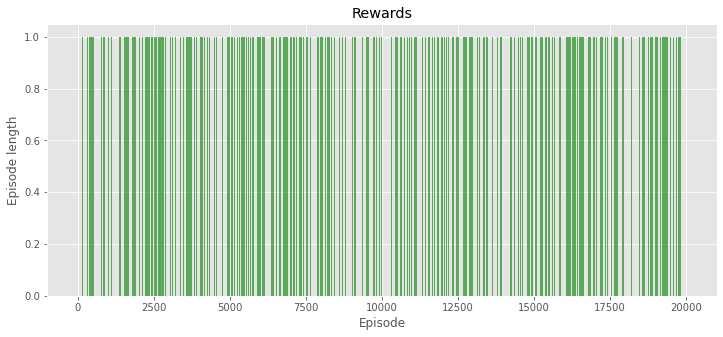

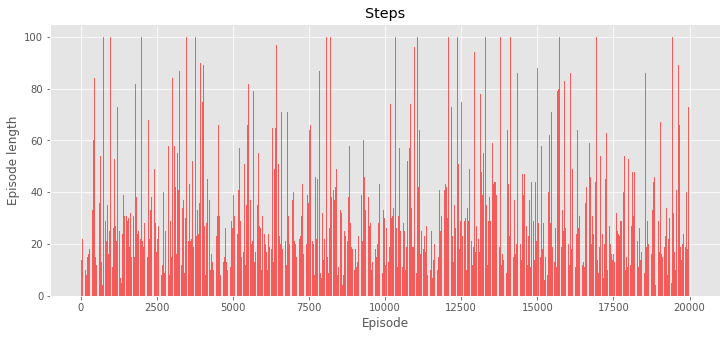

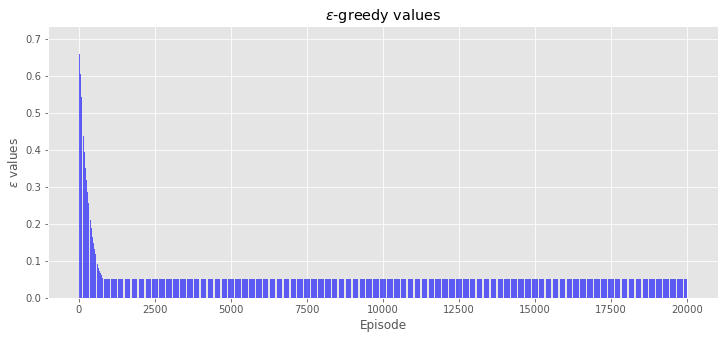

In [76]:
env = gym.make('FrozenLake-v0', is_slippery=True)

def expected_Sarsa(env, num_episodes=500, gamma=0.95, alpha=0.5, epsilon=0.7, print_i=50):

    def choose_action(Q, obs, epsilon=0.01):
        if np.random.normal() < epsilon:
            random_values = Q[obs] + np.random.randn(nA)/1000
            return np.argmax(random_values)
        else:
            return np.argmax(Q[obs])
        
    nS = env.observation_space.n
    nA = env.action_space.n
    
    # Track statistics
    rewards_total = []
    steps_total = []
    egreedy_total = []
    
    # Decaying epsilon greedy
    epsilon_final = 0.05
    epsilon_decay = 0.9999

#     Q = np.zeros([nS, nA]) #* 1/nA
    # Initialize Q
    Q = np.ones([nS, nA]) * 1/nA

    # Loop for each episode
    for i in range(num_episodes):
        # Initiatize S
        obs = env.reset()
        
        # Choose A from S using policy derived from Q,
        # using epsilon-greedy exploration
        action = choose_action(Q, obs, epsilon)

        # These will be the S and A variables in the while
        # loop.
        prev_obs = None
        prev_action = None

        steps = 0

        # Loop for each step of the episode
        while True:
            steps += 1

            # Take action A, observe R, S'
            obs, reward, done, info = env.step(action)
            # Choose A' from S' using policy derived from Q,
            # using epsilon-greedy exploration
            action = choose_action(Q, obs, epsilon)

            # Update the epsilon greedy decay
            if epsilon > epsilon_final:
                epsilon *= epsilon_decay

            # Skip the update for the first step
            if prev_obs is not None:
                # There will be no next A' and S' so,
                if done:
                    Q[prev_obs][prev_action] += alpha * (
                        reward - Q[prev_obs][prev_action])
                else:
                    # The update rule,
                    # Q(S, A) <- Q(S, A) + alpha [
                    #    R + gamma \sum_a Pi(a|S_t+1)Q(S_t+1, a) - Q(S, A)
                    # ]
                    
                    # The TD target, R + gamma \sum_a Pi(a| S_t+1)Q(S_t+1, a)
                    sum_term = (1/nA)*sum(Q[obs][a] for a in range(nA))
                    td_target = reward + sum_term
                    
                    # The TD error, R + gamma Q(S', A') - Q(S, A)
                    td_error = td_target - Q[prev_obs][prev_action]
                    # Finally, the update,
                    Q[prev_obs][prev_action] += alpha * td_error

            # S <- S', A <- A'
            prev_obs = obs
            prev_action = action 

            # until S is terminal
            if done:
                steps_total.append(steps)
                rewards_total.append(reward)
                egreedy_total.append(epsilon)
                if i % print_i == 0:
                    print("Episode finished after %i steps, with reward %i" % (steps, reward))
                break

    print_statistics(Q, num_episodes, rewards_total, steps_total, egreedy_total)

expected_Sarsa(env, num_episodes=20000, gamma=0.99, alpha=0.04, epsilon=0.7, print_i=1000)

Expected Sarsa converges extremely slowly on the environment, and obtain worse results than Q-learning. 